# cuSpatial Cheat Sheets sample code

(c) 2020 NVIDIA, Blazing SQL

Distributed under Apache License 2.0

## Imports

In [1]:
import cudf
import cuspatial
import numpy as np
import math
import cupy as cp

# Read data

In [2]:
ring, poly_idx, polygons = cuspatial.io.shapefile.read_polygon_shapefile('../data/gadm36_USA_1.shp')
polygons = polygons.rename(columns={'x': 'longitude', 'y': 'latitude'})
polygons['line'] = cp.random.randint(10,240, len(polygons))
polygons = polygons.query(
        'longitude > -130'
        ' and longitude < 70'
        ' and latitude < 50'
    )

## Querying geospatial data

In [72]:
np.random.seed(0)
points = cudf.DataFrame({
        "x": cudf.Series(np.random.normal(size=120)) * 500,
        "y": cudf.Series(np.random.normal(size=120)) * 500,
    })

max_depth = 3
min_size = 50
min_x, min_y, max_x, max_y = (points["x"].min(),
                                  points["y"].min(),
                                  points["x"].max(),
                                  points["y"].max())
scale = max(max_x - min_x, max_y - min_y) // (1 << max_depth)
print(
        "min_size:   " + str(min_size) + "\n"
        "num_points: " + str(len(points)) + "\n"
        "min_x:      " + str(min_x) + "\n"
        "max_x:      " + str(max_x) + "\n"
        "min_y:      " + str(min_y) + "\n"
        "max_y:      " + str(max_y) + "\n"
        "scale:      " + str(scale) + "\n"
    )

min_size:   50
num_points: 120
min_x:      -1276.4949079170394
max_x:      1134.877311993804
min_y:      -1111.7015761122134
max_y:      1191.572387431971
scale:      301.0



In [150]:
key_to_point, quadtree = cuspatial.quadtree_on_points(
        points["x"],
        points["y"],
        min_x,
        max_x,
        min_y,
        max_y,
        scale, max_depth, min_size
    )

print(quadtree)
print(key_to_point)

    key  level  is_quad  length  offset
0     0      0    False      33       0
1     1      0    False      37      33
2     2      0    False      18      70
3     3      0    False      31      97
4     6      0    False       1     159
5    38      2    False       1      88
6    39      2    False       5      89
7    41      2    False       1      94
8    45      2    False       1      95
9    47      2    False       1      96
10   48      2    False      10     128
11   49      2    False       6     138
12   50      2    False       1     144
13   51      2    False       1     145
14   52      2    False       4     146
15   53      2    False       3     150
16   54      2    False       1     153
17   55      2    False       1     154
18   56      2    False       2     155
19   57      2    False       1     157
20   58      2    False       1     158
21  106      2    False       1     160
0       63
1       20
2       66
3      117
4       19
      ... 
115     31
116

In [111]:
quadtree

,key,level,is_quad,length,offset
0,0,0,False,33,0
1,1,0,False,37,33
2,2,0,False,18,70
3,3,0,False,31,88
4,6,0,False,1,119


#### cuspatial.core.CubicSpline

In [3]:
t = cudf.Series(np.repeat(cp.arange(100), 1000)).astype('float32')
y = cudf.Series(np.random.random(100*1000)).astype('float32')

prefix_sum = cudf.Series(cp.arange(1000)*100).astype('int32')

new_samples = cudf.Series(
    np.repeat(np.linspace(0, 100, 1000), 1000)
).astype('float32')

curve = cuspatial.CubicSpline(t, y, prefixes=prefix_sum)
# new_points = curve(new_samples, prefix_sum*10)

#### cuspatial.core.spatial_window.points_in_spatial_window

In [10]:
wa_state = cuspatial.points_in_spatial_window(
    45.543541
    , 49.002494
    , -116.915989
    , -124.763068
    , polygons['latitude']
    , polygons['longitude']
).reset_index(drop=True)

wa_state['line'] = cp.random.randint(10,240, len(wa_state))
wa_state.head()

,x,y,line
0,49.000416,-116.942093,42
1,49.000031,-116.981636,82
2,48.999596,-117.026794,63
3,48.999615,-117.029434,50
4,48.942539,-117.030739,145


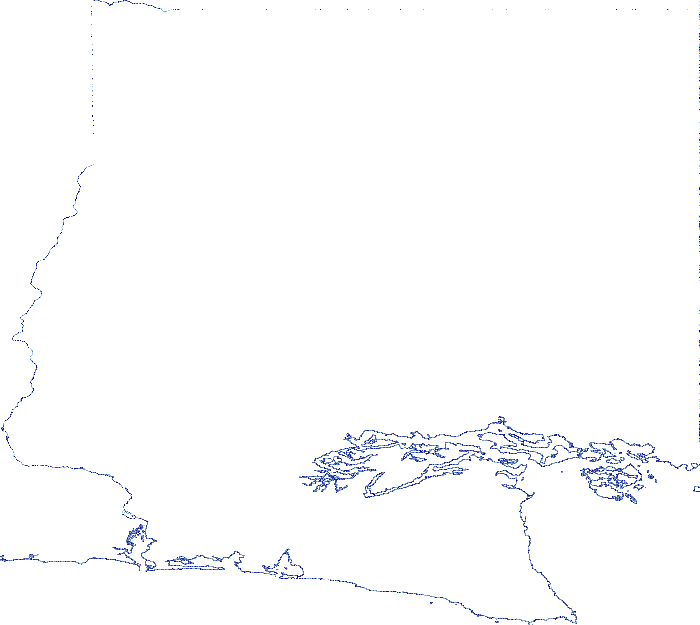

In [14]:
import datashader as ds
from datashader import transfer_functions as tf
from datashader.colors import Hot

cvs = ds.Canvas(plot_width=700, plot_height=625)
agg = cvs.points(wa_state, 'x', 'y', ds.mean('line')) # Perform aggregation
img = tf.shade(agg, cmap=['lightblue', 'darkblue'], how='eq_hist') # Produce image from aggregation

img

#### cuspatial.core.spatial_join.join_quadtree_and_bounding_boxes

In [3]:
bounding_boxes = cuspatial.polyline_bounding_boxes(
    poly_idx
    , polygons['longitude']
    , polygons['latitude']
    , 0.01
)

RuntimeError: transform: failed to synchronize: cudaErrorIllegalAddress: an illegal memory access was encountered

#### cuspatial.core.spatial_join.quadtree_point_in_polygon

#### cuspatial.core.spatial_join.quadtree_point_to_nearest_polyline

#### cuspatial.core.trajectory.derive_trajectories
#### cuspatial.core.trajectory.trajectory_bounding_boxes
#### cuspatial.core.trajectory.trajectory_distances_and_speeds